### Project Recommender Systems

In [91]:
# Import the necessary libraries 
import numpy as np   # Provides single and multi-dimensional arrays
import pandas as pd  # Provides DataFrames for easy data manipulations and statstical functions
import matplotlib.pyplot as plt  # Provides several functions for plotting various graphs
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [92]:
# Read electronic rating data into a dataframe
orig_rating_data = pd.read_csv('ratings_Electronics.csv', names=('UserId', 'ProductId', 'Rating', 'Timestamp'))
orig_rating_data.shape

# All the rows & features from data file are read into the dataframe

(7824482, 4)

In [93]:
# Make a copy of the original data so we dont have to load data again if we need to rollback our changes later
rating_df = orig_rating_data.copy()
rating_df.shape

# All the rows & features from original dataframe are copied into rating_df

(7824482, 4)

##### Exploratory Data Analysis

In [94]:
rating_df.head()

,UserId,ProductId,Rating,Timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [95]:
rating_df.tail()

,UserId,ProductId,Rating,Timestamp
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.0,1396569600
7824478,A322MDK0M89RHN,BT008UKTMW,5.0,1313366400
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.0,1404172800
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.0,1297555200
7824481,A2G81TMIOIDEQQ,BT008V9J9U,5.0,1312675200


In [96]:
# Get more info on the datatypes of the columns 
rating_df.info()

# There are 7824482 rows and 4 columns
# UserId & ProductId are alphanumeric and Rating is numeric. 
# Timestamp is numeric, Epoch Unix time. Will convert to datetime format later.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
UserId       object
ProductId    object
Rating       float64
Timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [97]:
# Check for missing values
rating_df.isnull().sum()

# There are no missing values in any of the columns

UserId       0
ProductId    0
Rating       0
Timestamp    0
dtype: int64

In [98]:
# Five point summary of all the variables
rating_df[['UserId', 'ProductId', 'Rating']].describe(include='all').T

# There are ~4.2 Million unique users, & user 'A5JLAU2ARJ0BO' the most prolific rater
# 476K unique products & 'B0074BW614' has been most rated ~18K times

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
UserId,7824482,4201696,A5JLAU2ARJ0BO,520,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProductId,7824482,476002,B0074BW614,18244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rating,7.82448e+06,NaN,NaN,NaN,4.01234,1.38091,1,3,5,5,5


In [99]:
# Convert Unix time to Datetime format & drop the Timestamp column
rating_df['DateTime'] = pd.to_datetime(rating_df['Timestamp'], unit='s')
rating_df.drop(columns='Timestamp', inplace=True, axis=1)

In [100]:
# The ratings data is captured between 1998 and 2014
rating_df['year'] = rating_df['DateTime'].dt.year

In [101]:
rating_df.head()

,UserId,ProductId,Rating,DateTime,year
0,AKM1MP6P0OYPR,0132793040,5.0,2013-04-13,2013
1,A2CX7LUOHB2NDG,0321732944,5.0,2012-07-01,2012
2,A2NWSAGRHCP8N5,0439886341,1.0,2013-04-29,2013
3,A2WNBOD3WNDNKT,0439886341,3.0,2013-07-22,2013
4,A1GI0U4ZRJA8WN,0439886341,1.0,2012-04-18,2012


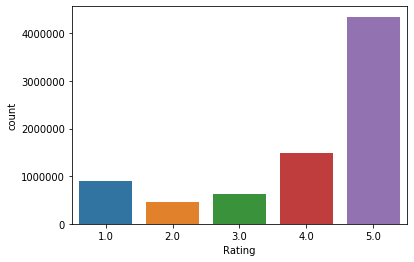

In [102]:
# What is the most common rating across products?
sns.countplot(data=rating_df, x='Rating')

# More than 50% of the ratings are 5
# The least used rating score is 2

In [103]:
# Lets look at the rating trends over the years
print(rating_df.groupby('year')['UserId'].count())

# We see that ratings have increased steeply over the years
# 2013 has more ratings than 2014, this may be because we have data only upto July in 2014

year
1998          4
1999       1212
2000       9214
2001      14753
2002      18648
2003      23117
2004      31245
2005      56311
2006      86659
2007     193430
2008     238521
2009     325380
2010     475626
2011     783503
2012    1231673
2013    2626582
2014    1708604
Name: UserId, dtype: int64


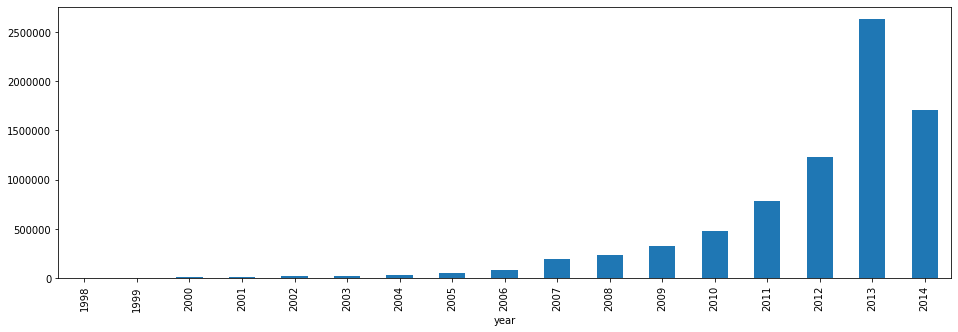

In [104]:
plt.figure(1, figsize=(16,5))
rating_df.groupby('year')['UserId'].count().plot(kind='bar')

In [105]:
# Count the number of unique users
len(rating_df['UserId'].unique())

4201696

In [106]:
# Count the number of unique products
len(rating_df['ProductId'].unique())

476002

In [107]:
import sys
is_64bits = sys.maxsize > 2**32
print(is_64bits)

True


In [108]:
# As the DateTime and Year columns are not needed for this project, we will drop them
rating_df.drop(columns=['DateTime', 'year'], axis=1, inplace=True)
rating_df.head()

,UserId,ProductId,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [109]:
# To reduce the dimensionality of the data set, and avoid running into “memory error”, 
# we will filter out rarely rated products and rarely rating users
min_prod_ratings = 50
filter_prods = rating_df['ProductId'].value_counts() > min_prod_ratings
filter_prods = filter_prods[filter_prods].index.tolist()

min_user_ratings = 50
filter_users = rating_df['UserId'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

rating_df_new = rating_df[(rating_df['ProductId'].isin(filter_prods)) & (rating_df['UserId'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(rating_df.shape))
print('The new data frame shape:\t{}'.format(rating_df_new.shape))

The original data frame shape:	(7824482, 3)
The new data frame shape:	(76359, 3)


In [110]:
rating_df_new.head()

,UserId,ProductId,Rating
492,A3CLWR1UUZT6TG,0972683275,5.0
631,A3TAS1AG6FMBQW,0972683275,5.0
1138,A25RTRAPQAJBDJ,0972683275,5.0
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0


#### Split data into train and test

In [111]:
from sklearn.model_selection import train_test_split

In [112]:
train_data, test_data = train_test_split(rating_df_new, test_size=0.20, random_state=0)
print(train_data.head(5))

                 UserId   ProductId  Rating
4411311  A2WPL6Y08K6ZQH  B004S4R5CK     5.0
1032999  A2UOHALGF2X77Q  B000I68BD4     4.0
956700   A3FPSY1M6G7XIB  B000FW1X4K     3.0
6411065   AL1XV4L25FZ2S  B008YFB4FS     5.0
457688   A19W47CXJJP1MI  B0002DG9XW     5.0


#### Popularity-Based Recommender model

In [113]:
#Count of UserId for each unique ProductId as recommendation score 
train_data_grouped = train_data.groupby('ProductId').agg({'UserId': 'count'}).reset_index()
train_data_grouped.rename(columns={'UserId':'Score'}, inplace=True)
train_data_grouped.head()

,ProductId,Score
0,0972683275,2
1,1400501466,4
2,1400501520,1
3,1400501776,2
4,1400532620,2


In [114]:
# Sort the songs on recommendation score 
train_data_sort = train_data_grouped.sort_values(['Score', 'ProductId'], ascending = [0,1]) 
      
# Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['Score'].rank(ascending=0, method='first') 
          
# Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,ProductId,Score,Rank
12550,B0088CJT4U,156,1.0
7694,B003ES5ZUU,137,2.0
2980,B000N99BBC,135,3.0
12328,B007WTAJTO,118,4.0
12439,B00829TIEK,118,5.0


In [115]:
# For the test set, recommendations remain the same for all users as this is a popularity-based recommender model
# The predictions of the products are based entirely on popularity & is not personalized to particular user

#### Build Collaborative Filtering model

In [116]:
# Import KNNWithMeans package from Surprise Library
from surprise import KNNWithMeans
from surprise import accuracy
from surprise import Reader
from surprise import Dataset

In [117]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_df_new[['UserId', 'ProductId', 'Rating']], reader)

In [118]:
from surprise.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size = 0.40, random_state=0)

In [119]:
# Create a df to hold the results of the different models
results = pd.DataFrame(columns=['Model Name', 'RMSE'])
results

,Model Name,RMSE


##### User Based Collaborative Filtering

In [120]:
# Since we want to recommend products for users based on his/her habits, we will use 
# User-based collaborative filtering
algo = KNNWithMeans(k=20, sim_options={'name':'pearson_baseline', 'user_based':True})
algo.fit(train_data)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [121]:
# Run the trained model against the testset
test_pred = algo.test(test_data)

In [122]:
# Get RMSE
# print('User Based Model: Test Set')
user_rmse = accuracy.rmse(test_pred, verbose=True)
results = results.append({'Model Name':'User Based Collab Filtering', 'RMSE':user_rmse}, ignore_index=True)

RMSE: 1.0287


,Model Name,RMSE
0,User Based Collab Filtering,1.028682


In [123]:
# Get the top 5 predictions
pred_df = pd.DataFrame.from_dict(test_pred)
pred_df.sort_values(by='est', ascending=False).head()

,uid,iid,r_ui,est,details
12258,A2HNH4PKE5DPSI,B0016P15E8,4.0,5.0,"{'actual_k': 1, 'was_impossible': False}"
27733,A96JD9312DHWC,B004CLYEFK,5.0,5.0,"{'actual_k': 7, 'was_impossible': False}"
12685,A2VAD79S4A06DD,B0088CJT4U,5.0,5.0,"{'actual_k': 8, 'was_impossible': False}"
12671,A1SB9BNNGKNX2Z,B00AQRUW4Q,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}"
3487,A27H0T39U3FZB5,B004DI7DFU,3.0,5.0,"{'actual_k': 1, 'was_impossible': False}"


##### Item Based Collaborative Filtering

In [124]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(train_data)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [125]:
# Run the trained model against the testset
test_pred = algo.test(test_data)

In [127]:
# Get RMSE
# print('User Based Model: Test Set')
item_rmse = accuracy.rmse(test_pred, verbose=True)
results = results.append({'Model Name':'Item Based Collab Filtering', 'RMSE':item_rmse}, ignore_index=True)

RMSE: 1.1284


In [128]:
# Get the top 5 predictions
pred_df = pd.DataFrame.from_dict(test_pred)
pred_df.sort_values(by='est', ascending=False).head()

,uid,iid,r_ui,est,details
0,A19X4BF861LQST,B00740MR78,3.0,5.0,"{'actual_k': 0, 'was_impossible': False}"
13435,A34BZM6S9L7QI4,B008ULPAT2,5.0,5.0,"{'actual_k': 10, 'was_impossible': False}"
13422,A2UOHALGF2X77Q,B00006IS4X,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}"
13424,A14MZJTZAQS6CV,B00009USW3,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}"
13425,A1F9Z42CFF9IAY,B0049MOK92,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}"


In [129]:
# Display the RMSE from all the models
results

,Model Name,RMSE
0,User Based Collab Filtering,1.028682
1,Item Based Collab Filtering,1.128448


In [130]:
# Conclusion
# I have tried three different methods for recommending the best products to the users:
# Popularity Based Recommender: Since the recommendation is based on popularity, all test users get recommendations for the 
#                               same products. But we want to recommend new products to users based on their habits, we will 
#                               use the collborative filtering models.
# User-Based Recommender: User count was very large compared to item count, hence we had to trim down the number by using a 
#                         criteria of min_rating_user>50 and items_with_min_rating>50
#                         Checked with multiple hyperparameters (different k) but the change in RMSE was not significant.
# Item-Based Recommender: Inspite of reducing dimentionality of data, ran into a memory error with this recommender 
#                         but was able to address this by running on a higher config machine.

# Since the RMSE from User-Based recommender is less than that of the Item-Based Recommender, 
# we can conclude that the User-Based approach is better for our data. For cold-start or grey-sheep problems we can 
# use Popularity based recommender to begin with until more data is gathered for the particular user/item.